## 0. Import Libraries

In [39]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
import metpy.calc as mpcalc
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy, vertcross
from netCDF4 import Dataset
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from metpy.units import units

import warnings
warnings.filterwarnings('ignore')

## 1. Open ERA5

In [48]:
run_data = 'era5'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

### 1.1 Open Specific Humidity Data

In [49]:
variable = 'spehum'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_spehum = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

dt_spehum_era5 = dt_spehum.rename({'__xarray_dataarray_variable__':variable}) * 1000

### 1.2 Open U

In [50]:
variable = 'ua'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_u_era5 = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

### 1.3 Open V

In [51]:
variable = 'va'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_v_era5 = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

### 1.4 Open P

In [52]:
variable = 'PRESSURE'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_p_era5 = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

### 1.5 Define Members

In [53]:
def define_ensemble(var, ens_type):
    # ensemble member list
    ensemble_members = [fr'LIN_nourban_{var}',
     fr'LIN_urban_{var}',
     fr'THOMPSON_nourban_{var}',
     fr'THOMPSON_urban_{var}',
     fr'WSM6_nourban_{var}',
     fr'WSM6_urban_{var}']
    
    nourban = [ens for ens in ensemble_members if 'nourban' in ens ]
    urban = [ens for ens in ensemble_members if not 'nourban' in ens ]
    
    if ens_type == 'urban':
        return urban
    else:
        return nourban

### 1.6 Calculate Moisture Flux

In [101]:
level = 500
dt_u_interp_era5 = interplevel(dt_u_era5['ua'], dt_p_era5['PRESSURE'], level)
dt_v_interp_era5 = interplevel(dt_v_era5['va'], dt_p_era5['PRESSURE'], level)
dt_spehum_interp_era5 = interplevel(dt_spehum_era5['spehum'], dt_p_era5['PRESSURE'], level)

In [102]:
# q*u + q*v
qu_urb_era5 = dt_spehum_interp_era5.sel(ens=define_ensemble('td', 'urban')).mean(dim='ens')*\
          dt_u_interp_era5.sel(ens=define_ensemble('ua', 'urban')).mean(dim='ens')
    
qv_urb_era5 = dt_spehum_interp_era5.sel(ens=define_ensemble('td', 'urban')).mean(dim='ens')*\
          dt_v_interp_era5.sel(ens=define_ensemble('va', 'urban')).mean(dim='ens')
    
qu_nourb_era5 = dt_spehum_interp_era5.sel(ens=define_ensemble('td', 'nourban')).mean(dim='ens')*\
          dt_u_interp_era5.sel(ens=define_ensemble('ua', 'nourban')).mean(dim='ens')
    
qv_nourb_era5 = dt_spehum_interp_era5.sel(ens=define_ensemble('td', 'nourban')).mean(dim='ens')*\
          dt_v_interp_era5.sel(ens=define_ensemble('va', 'nourban')).mean(dim='ens')

dt_moisture_flux_urban_era5 = (qu_urb_era5+qv_urb_era5).mean(dim='time')
dt_moisture_flux_nourban_era5 = (qu_nourb_era5+qv_nourb_era5).mean(dim='time')

## 2. Open GFS

In [40]:
run_data = 'gfs'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

### 1.1 Open Specific Humidity Data

In [41]:
variable = 'spehum'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_spehum = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

dt_spehum_gfs = dt_spehum.rename({'__xarray_dataarray_variable__':variable}) * 1000

### 1.2 Open U

In [42]:
variable = 'ua'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_u_gfs = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

### 1.3 Open V

In [43]:
variable = 'va'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_v_gfs = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

### 1.4 Open P

In [44]:
variable = 'PRESSURE'
# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')

# instead of 201 grid we want 200 grid in each direction
dt_p_gfs = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

### 1.5 Define Members

In [45]:
def define_ensemble(var, ens_type):
    # ensemble member list
    ensemble_members = [fr'LIN_nourban_{var}',
     fr'LIN_urban_{var}',
     fr'THOMPSON_nourban_{var}',
     fr'THOMPSON_urban_{var}',
     fr'WSM6_nourban_{var}',
     fr'WSM6_urban_{var}']
    
    nourban = [ens for ens in ensemble_members if 'nourban' in ens ]
    urban = [ens for ens in ensemble_members if not 'nourban' in ens ]
    
    if ens_type == 'urban':
        return urban
    else:
        return nourban

### 1.6 Calculate Moisture Flux

In [103]:
dt_u_interp_gfs = interplevel(dt_u_gfs['ua'], dt_p_gfs['PRESSURE'], level)
dt_v_interp_gfs = interplevel(dt_v_gfs['va'], dt_p_gfs['PRESSURE'], level)
dt_spehum_interp_gfs = interplevel(dt_spehum_gfs['spehum'], dt_p_gfs['PRESSURE'], level)

In [104]:
# q*u + q*v
qu_urb_gfs = dt_spehum_interp_gfs.sel(ens=define_ensemble('td', 'urban')).mean(dim='ens')*\
          dt_u_interp_gfs.sel(ens=define_ensemble('ua', 'urban')).mean(dim='ens')
    
qv_urb_gfs = dt_spehum_interp_gfs.sel(ens=define_ensemble('td', 'urban')).mean(dim='ens')*\
          dt_v_interp_gfs.sel(ens=define_ensemble('va', 'urban')).mean(dim='ens')
    
qu_nourb_gfs = dt_spehum_interp_gfs.sel(ens=define_ensemble('td', 'nourban')).mean(dim='ens')*\
          dt_u_interp_gfs.sel(ens=define_ensemble('ua', 'nourban')).mean(dim='ens')
    
qv_nourb_gfs = dt_spehum_interp_gfs.sel(ens=define_ensemble('td', 'nourban')).mean(dim='ens')*\
          dt_v_interp_gfs.sel(ens=define_ensemble('va', 'nourban')).mean(dim='ens')

dt_moisture_flux_urban_gfs = (qu_urb_gfs+qv_urb_gfs).mean(dim='time')
dt_moisture_flux_nourban_gfs = (qu_nourb_gfs+qv_nourb_gfs).mean(dim='time')

## 4. Plot

### 4.1 Options

In [69]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'data/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

In [70]:
# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

In [110]:
# Parameters to change (plot) -------------------
# projection
# assign projection and dim info
dt_proj = dt_p_era5.copy(deep=True)
dt_proj = dt_proj.rio.write_crs(dt_proj['PRESSURE'].attrs['pyproj_srs'])
dt_proj = dt_proj.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')
proj = dt_proj.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1,2],
             [3,4]
            ]
graphic_no = 4

import matplotlib
cmap = plt.get_cmap('seismic')
clevs_total = np.arange(-40, 41, 5)
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = clevs_total

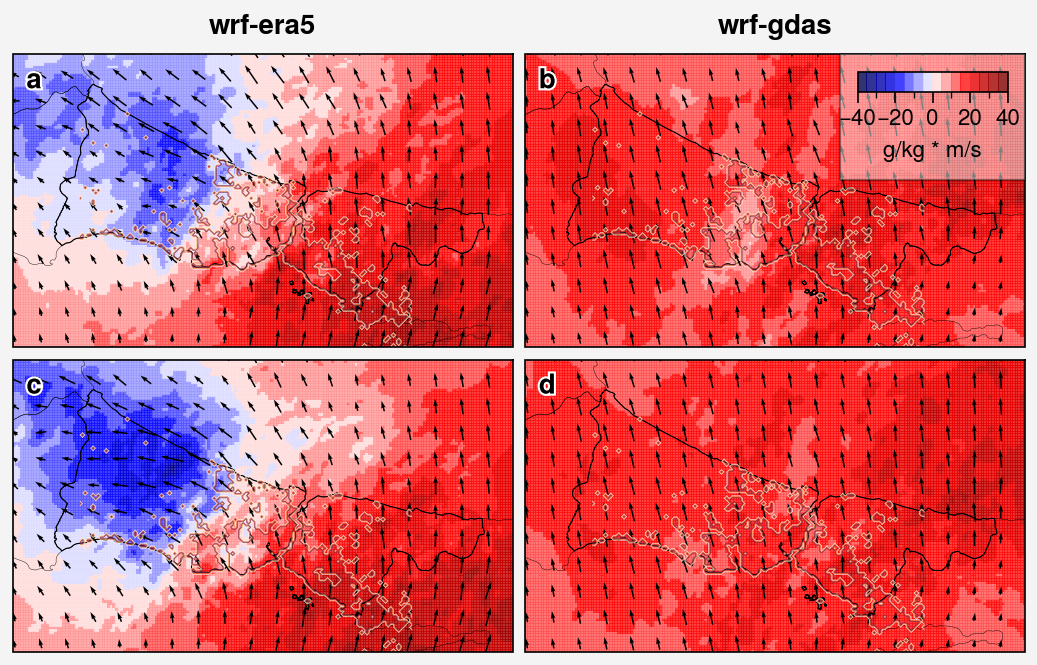

In [111]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            #aspect=4,
                            #axwidth=2,
                            proj=[lcc, lcc, lcc, lcc],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.50,
                            wspace=0.5,
                            #share = 0,
                            sharex=4,
                            sharey = 4
                           )

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs[:4].format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['wrf-era5', 'wrf-gdas'],
           )

# add shapefiles
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)

# spatial graphics
dt_border = urban_luse_border

for i in range(int(graphic_no)):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)  
    contour = axs[i].contour(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            linewidth = 0.1
                            )

# ERA5
mesh = axs[0].pcolormesh(dt_moisture_flux_urban_era5['XLONG'], 
                            dt_moisture_flux_urban_era5['XLAT'],
                            dt_moisture_flux_urban_era5, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8,
                            #extend = 'max'
                                )
quiver = axs[0].quiver(qu_urb_era5.mean(dim='time')[::10, ::10]['XLONG'], 
                        qu_urb_era5.mean(dim='time')[::10, ::10]['XLAT'],
                        qu_urb_era5.mean(dim='time')[::10, ::10],
                        qv_urb_era5.mean(dim='time')[::10, ::10],
                        zorder = 0.2,
                       pivot='middle', 
                        #extend = 'max'
                            )

mesh = axs[2].pcolormesh(dt_moisture_flux_nourban_era5['XLONG'], 
                            dt_moisture_flux_nourban_era5['XLAT'],
                            dt_moisture_flux_nourban_era5, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8,
                            #extend = 'max'
                                )

quiver = axs[2].quiver(qu_nourb_era5.mean(dim='time')[::10, ::10]['XLONG'], 
                        qu_nourb_era5.mean(dim='time')[::10, ::10]['XLAT'],
                        qu_nourb_era5.mean(dim='time')[::10, ::10],
                        qv_nourb_era5.mean(dim='time')[::10, ::10],
                        zorder = 0.2,
                       pivot='middle', 
                        #extend = 'max'
                            )

# GFS
mesh = axs[1].pcolormesh(dt_moisture_flux_urban_gfs['XLONG'], 
                            dt_moisture_flux_urban_gfs['XLAT'],
                            dt_moisture_flux_urban_gfs, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8,
                            #extend = 'max'
                                )
quiver = axs[1].quiver(qu_urb_gfs.mean(dim='time')[::10, ::10]['XLONG'], 
                        qu_urb_gfs.mean(dim='time')[::10, ::10]['XLAT'],
                        qu_urb_gfs.mean(dim='time')[::10, ::10],
                        qv_urb_gfs.mean(dim='time')[::10, ::10],
                        zorder = 0.2,
                       pivot='middle', 
                        #extend = 'max'
                            )

mesh = axs[3].pcolormesh(dt_moisture_flux_nourban_gfs['XLONG'], 
                            dt_moisture_flux_nourban_gfs['XLAT'],
                            dt_moisture_flux_nourban_gfs, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8,
                            #extend = 'max'
                                )

quiver = axs[3].quiver(qu_nourb_gfs.mean(dim='time')[::10, ::10]['XLONG'], 
                        qu_nourb_gfs.mean(dim='time')[::10, ::10]['XLAT'],
                        qu_nourb_gfs.mean(dim='time')[::10, ::10],
                        qv_nourb_gfs.mean(dim='time')[::10, ::10],
                        zorder = 0.2,
                       pivot='middle', 
                        #extend = 'max'
                            )

# colorbars
axs[1].colorbar(mesh,
                 label='g/kg * m/s',
                 ticks = ticks,
                 loc='ur', length=6,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.8,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=True,
                )

#save figure
plt.savefig(fr'pictures/era5_ENS_moisture_flux_6hour_mean_{level}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)